In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import iqr, shapiro
import scipy.stats as st

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

from sklearn.linear_model import LinearRegression

import warnings

folder = "D:/Openclassrooms_DataScientist/Projet_3/donnees/"

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 400)

In [12]:
data = pd.read_csv(folder+'data_2.csv', index_col=0)
data.head()

,Quartier,AgeBatiment,NombreUtilisations,PremierTypePropriete,NombreBatiments,NombreEtages,SurfacePlancherTotal,SurfaceTotaleParking,SurfaceTotaleHorsParking,ListeUtilisationsBatiment,UtilisationPrincipale,SurfaceUtilisationPrincipale,UtilisationSecondaire,SurfaceUtilisationSecondaire,UtilisationTertiaire,SurfaceUtilisationTertiaire,Conformité,ConsoSite/S(kBtu/sf),ConsoSiteNorm/S(kBtu/sf),ConsoSource/S(kBtu/sf),ConsoSourceNorm/S(kBtu/sf),ConsoSiteTot(kBtu),ConsoSiteTotNorm(kBtu),Vapeur(kBtu),Électricité(kBtu),GazNaturel(kBtu),EmissionGES,IntensiteGES/S,TrancheAge,Pertes/S(kBtu/sf),ProportionVapeur,ProportionElectricité,ProportionGazNaturel
0,DOWNTOWN,89,1,Hotel,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,Aucune,0.0,Aucune,0.0,Compliant,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,3946027.0,1276453.0,249.98,2.83,"[87,116[",100.800003,0.277302,0.546060,0.176638
1,DOWNTOWN,20,3,Hotel,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,Compliant,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,3242851.0,5145082.0,295.86,2.86,"[0,29[",81.300003,0.000000,0.386609,0.613391
2,DOWNTOWN,47,1,Hotel,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,Aucune,0.0,Aucune,0.0,Compliant,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,49526664.0,1493800.0,2089.28,2.19,"[29,58[",145.899994,0.297113,0.682307,0.020579
3,DOWNTOWN,90,1,Hotel,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,Aucune,0.0,Aucune,0.0,Compliant,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,2768924.0,1811213.0,286.43,4.67,"[87,116[",105.399994,0.325913,0.407519,0.266567
4,DOWNTOWN,36,3,Hotel,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,Compliant,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,5368607.0,8803998.0,505.01,2.88,"[29,58[",96.599991,0.000000,0.378802,0.621198


In [13]:
# lmplot pour afficher une courbe de regression dans un nuage de point 

In [14]:
data.isna().sum()

Quartier                        0
AgeBatiment                     0
NombreUtilisations              0
PremierTypePropriete            0
NombreBatiments                 0
NombreEtages                    0
SurfacePlancherTotal            0
SurfaceTotaleParking            0
SurfaceTotaleHorsParking        0
ListeUtilisationsBatiment       0
UtilisationPrincipale           0
SurfaceUtilisationPrincipale    0
UtilisationSecondaire           0
SurfaceUtilisationSecondaire    0
UtilisationTertiaire            0
SurfaceUtilisationTertiaire     0
Conformité                      0
ConsoSite/S(kBtu/sf)            0
ConsoSiteNorm/S(kBtu/sf)        0
ConsoSource/S(kBtu/sf)          0
ConsoSourceNorm/S(kBtu/sf)      0
ConsoSiteTot(kBtu)              0
ConsoSiteTotNorm(kBtu)          0
Vapeur(kBtu)                    0
Électricité(kBtu)               0
GazNaturel(kBtu)                0
EmissionGES                     0
IntensiteGES/S                  0
TrancheAge                      0
Pertes/S(kBtu/

# Création du modèle 1

In [40]:
data2 = data[['Quartier', 'PremierTypePropriete', 'SurfacePlancherTotal', 'AgeBatiment', 'ConsoSiteTot(kBtu)']]
target = 'ConsoSiteTot(kBtu)'

### Création des jeux de données

In [41]:
def creation_train_test_set(data, target):
    
    # colonnes categ
    var_categ = list(data.select_dtypes(include='object').columns)

    # data categ 2
    data_categ = data.select_dtypes(include='object')
    
    # colonnes num
    var_num = list(data.drop(columns=target).select_dtypes(exclude='object').columns)

    # data num 2
    data_num = data.drop(columns=target).select_dtypes(exclude='object')
    
    # création du train et test set
    data_train, data_test = train_test_split(data, test_size=0.2)
    
    return data_train, data_test, var_categ, data_categ, var_num, data_num

In [42]:
data_train, data_test, var_categ, data_categ, var_num, data_num = creation_train_test_set(data2, target)

In [43]:
print(f"Les dimensions du train_set sont {data_train.shape}")
print(f"Les dimensions du test_set sont {data_test.shape}")

Les dimensions du train_set sont (1219, 5)
Les dimensions du test_set sont (305, 5)


### Preprocessing

In [44]:
def preprocessing(data, target, var_categ, var_num):    

    # Encodage
    encoder = OrdinalEncoder()
    #encoder = OneHotEncoder()

    data_encoder = encoder.fit_transform(data[var_categ])
    
    # Transformation
    #var_normal2 = ['Vapeur(kBtu)', 'Électricité(kBtu)', 'GazNaturel(kBtu)']
    #data[var_normal2] = np.log(data[var_normal2]).replace(-np.inf, 0)
    
    # Standardisation
    scaler = StandardScaler()

    data_scaler = scaler.fit_transform(data[var_num])

    # concaténation des 2 preprocessing
    #df_scaled = pd.DataFrame(np.concatenate((data_encoder, data_scaler), axis=1), columns=var_categ+var_num)
    df_scaled = pd.DataFrame(np.concatenate((data_encoder, data[var_num]), axis=1), columns=var_categ+var_num)

    y = data[target].values
    X = df_scaled.values
    columns = list(df_scaled.columns)
    
    return X, y, columns

### Modélisation

In [45]:
def modelisation(data_train, data_test, target):
    
    # creation X_train et y_train
    X_train, y_train, columns = preprocessing(data_train, target, var_categ, var_num)
    # creation X_test et y_test
    X_test, y_test, columns = preprocessing(data_test, target, var_categ, var_num)
    
    # creation de l'estimateur
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    
    return reg.score(X_test, y_test), reg, X_train, X_test, y_train, y_test, columns

In [46]:
score, reg, X_train, X_test, y_train, y_test, columns = modelisation(data_train, data_test, target)

### Régression avec stats model

In [47]:
data_train, data_test, var_categ, data_categ, var_num, data_num = creation_train_test_set(data2, target)
score, reg, X_train, X_test, y_train, y_test, columns = modelisation(data_train, data_test, target)

# ajout de la colonne de biais
df_X_train = pd.DataFrame(X_train, columns=columns)
df_X_test = pd.DataFrame(X_test, columns=columns)
X_train_sm = sm.add_constant(df_X_train)
X_test_sm = sm.add_constant(df_X_test)

results = sm.OLS(y_train, X_train_sm).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     224.3
Date:                Thu, 10 Aug 2023   Prob (F-statistic):          3.57e-144
Time:                        14:14:14   Log-Likelihood:                -21798.
No. Observations:                1219   AIC:                         4.361e+04
Df Residuals:                    1214   BIC:                         4.363e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3.508e+06   1.58e+06      2.226      0.026    4.17e+05     6.6e+06
Quartier              9.194e+04   1.41e+05      0.652      0.515   -1.85e+05    3.69e+05
PremierTypePropriete  -2.44e+05   7.22e+04     -3.378      0.001   -3.86e+05   -1.02e+05
SurfacePlancherTotal    59.6339      2.257     26.423      0.000      55.206      64.062
AgeBatiment          -3086.7938    1.3e+04     -0.237      0.812   -2.86e+04    2.24e+04
==============================================================================
Omnibus:                     1944.318   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1031399.117
Skew:                           9.820   Prob(JB):                         0.00
Kurtosis:                     144.141   Cond. No.                     8.77e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Calcul des VIF

In [48]:
vif = [variance_inflation_factor(X_train_sm, i) for i in range(X_train_sm.shape[1])]
df_vif = pd.DataFrame(vif, index=X_train_sm.columns, columns=['VIF'])
df_vif

,VIF
const,15.120397
Quartier,1.055756
PremierTypePropriete,1.123307
SurfacePlancherTotal,1.174003
AgeBatiment,1.099839


#### Score sur jeu de test

In [49]:
X_test_sm = sm.add_constant(X_test)

y_pred = results.predict(X_test_sm)

r_squared = r2_score(y_test, y_pred)

r_squared

0.42706108510145735

#### Importances des variables

In [50]:
results.tvalues

const                    2.226473
Quartier                 0.651848
PremierTypePropriete    -3.378033
SurfacePlancherTotal    26.423024
AgeBatiment             -0.237335
dtype: float64

#### Stabilité du modèle

0.39277963934360993
0.39557848196583223


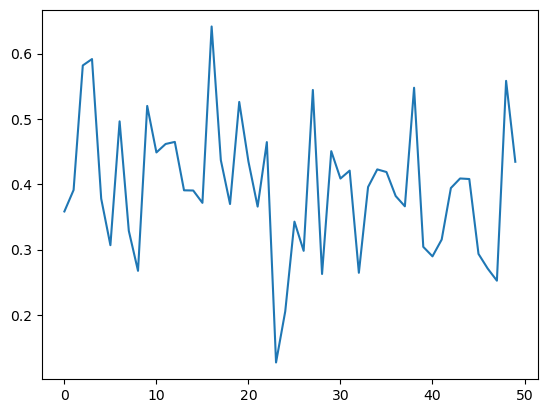

In [51]:
score_iteration = []

for i in range(50):
    
    data_train, data_test, var_categ, data_categ, var_num, data_num = creation_train_test_set(data2, target)
    score, reg, X_train, X_test, y_train, y_test, columns = modelisation(data_train, data_test, target)

    # ajout de la colonne de biais
    df_X_train = pd.DataFrame(X_train, columns=columns)
    df_X_test = pd.DataFrame(X_test, columns=columns)
    X_train_sm = sm.add_constant(df_X_train)
    X_test_sm = sm.add_constant(df_X_test)

    results = sm.OLS(y_train, X_train_sm).fit()

    X_test_sm = sm.add_constant(X_test)

    y_pred = results.predict(X_test_sm)

    r_squared = r2_score(y_test, y_pred)
    
    score_iteration.append(r_squared)
    
plt.plot(range(len(score_iteration)), score_iteration)

print(np.median(np.array(score_iteration)))
print(np.array(score_iteration).mean())

#### Analyse des résidus

223539156.60020834


ShapiroResult(statistic=0.4049460291862488, pvalue=0.0)

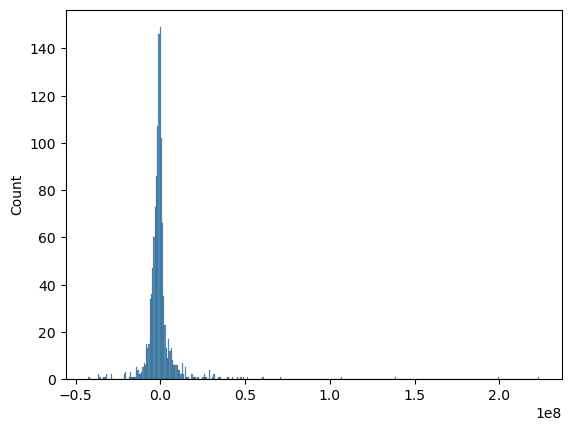

In [27]:
print(results.resid.max())

sns.histplot(results.resid)

shapiro(results.resid)

Le test statistique n'est pas passé mais l'allule de la distribution est normale.